In [1]:
#pip install google-generativeai
import sys
sys.setrecursionlimit(100000)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_colwidth', None)


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

model = genai.GenerativeModel("gemini-2.0-flash")



True

In [4]:
import os
from typing import List,TypedDict
from langgraph.graph import StateGraph,END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

2025-12-05 18:26:15.035904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 18:26:15.481125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 18:26:17.744649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
emb = HuggingFaceBgeEmbeddings(model_name="thenlper/gte-small")

/tmp/ipykernel_6884/2730872305.py:2: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  emb = HuggingFaceBgeEmbeddings(model_name="thenlper/gte-small")


In [6]:
from langchain_community.document_loaders import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup

# 1. Define the Root URL (Where to start)
# Note: LangChain docs structure changes often. Ensure this is the active root.
url = "https://python.langchain.com/v0.2/docs/introduction/" 

# 2. Configure the Loader
loader = RecursiveUrlLoader(
    url=url,
    max_depth=2, # How deep to dig? (Root -> Child -> Grandchild)
    # This specifically filters for the main content div to avoid navbars/footers
    extractor=lambda x: Soup(x, "html.parser").text 
)

# 3. Load the docs
document = loader.load()

print(f"Loaded {len(document)} documents.")

Loaded 47 documents.


In [7]:
print(document[6])


page_content='LangChain overview - Docs by LangChainSkip to main content🚀 Share how you're building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith StudioTestAgent Chat UIDeploy with LangSmithDeploymentObservabilityOn this page Create an agent Core benefitsLangChain overviewCopy pageCopy pageLangChain v1.x is now available!For a complete list of changes and instructions on how to upgrade your code, see the release notes and migration guide.If you encounter

In [8]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_template("""
Answer the following question based on the provided context. 
Also if any code snippet is available please provide it.
Always answer for more then 100 words. 
<context>
{context}
</context>
Question : {input}""")

In [9]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [10]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500
)

docs = splitter.split_documents(document)

In [11]:
vectorstore = FAISS.from_documents(docs,embedding=emb)

In [12]:
retriever = vectorstore.as_retriever(k=3)


In [15]:
# context_docs = retriever.invoke("Give to me in detail about how to use agents in langchain")
# context = format_docs(context_docs)

# final_prompt = prompt.format(context=context, input="Give to me in detail about how to use agents in langchain")

# response = model.generate_content(final_prompt)
# print(response.text)


In [50]:
# print(context_docs)
retrieval = False

In [51]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer:str
    needs_retrieval: bool

In [66]:
def decide_retrieval(state: AgentState) -> AgentState:
    question = state["question"]
    
    response = model.generate_content(
        f"""Return ONLY True or False.

        True → This question REQUIRES consulting the knowledge base because it relates to
        AI, machine learning, deep learning, LLMs, LangChain, agents, RAG, embeddings,
        vector databases, or any technical framework covered in the documents.

        False → The question is general knowledge, unrelated to the stored documentation.

        Do NOT decide based on whether the LLM personally knows the answer.
        Decide ONLY based on whether retrieval would provide more accurate,
        context-specific, or implementation-specific information.

        Question: {question}

        """
    )
    
    cleaned = response.text.strip().lower()
    needs_retrieval = cleaned.startswith("t")
    
    return {**state, "needs_retrieval": needs_retrieval}

In [67]:
def retrieve_documents(state:AgentState) -> AgentState:
    question = state['question']

    documents = retriever.invoke(question)

    return {**state,"documents":documents}

In [68]:
def generate_answer(state:AgentState) -> AgentState:
    question = state['question']
    documents = state.get("documents",[])

    if documents:
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""
                    Based on the following context, answer the question : 
                    Context : {context}
                    Question : {question}
                    Answer : 
                    """
    else:
        prompt = f"Answer the following question : {question}"
    response = model.generate_content(prompt)
    answer = response

    return {**state,"answer":answer}

In [69]:
def should_retrieve(state:AgentState) -> AgentState:
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

In [70]:
workflow = StateGraph(AgentState)

workflow.add_node("decide",decide_retrieval)
workflow.add_node("retrieve",retrieve_documents)
workflow.add_node("generate",generate_answer)

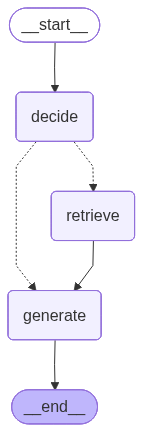

In [71]:
workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve" : "retrieve",
        "generate" : "generate"
    }

)

workflow.add_edge("retrieve","generate")
workflow.add_edge("generate",END)

app = workflow.compile()
app

In [72]:
def ask_question(question:str):
    initial_state = {
        "question" : question,
        "documents" : [],
        "answer" : "",
        "needs_retrieval" : False
    }
    result = app.invoke(initial_state)
    return result

In [73]:
question = "How to build agents using langchain"
result = ask_question(question)
answer = result

In [74]:
print(answer['answer'].text)

LangChain provides a pre-built agent architecture and model integrations to help you get started quickly and seamlessly incorporate LLMs into your agents and applications. You can connect to OpenAI, Anthropic, Google, and more with under 10 lines of code.



In [75]:
print(result)

{'question': 'How to build agents using langchain', 'documents': [Document(id='090ed21c-a672-4bfd-9fe6-b54db1b558e6', metadata={'source': 'https://python.langchain.com/v0.2/docs/introduction/', 'content_type': 'text/html; charset=utf-8', 'title': 'LangChain overview - Docs by LangChain', 'language': 'en'}, page_content="LangChain overview - Docs by LangChainSkip to main content🚀 Share how you're building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith Stud